# Imports

In [1]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
set_global("dataloader_workers", 4)
set_global("use_autocast", True)
set_global("models_dir", "/home/ahemf/cache/")

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device, print_code
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, VilBertVisualBertModel
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, my_collate, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment, DefinedAffine, DefinedColorJitter, DefinedRandomPerspective
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)


In [2]:


choice_probas = {"keyboard": 0.1, "char_substitute": 0.0, "char_insert": 0.1, "char_swap": 0.0, "ocr": 0.0, "char_delete": 0.1,
                 "fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.1,
                 "stopword_insert": 0.3, "word_join": 0.1, "word_cutout": 0.8,
                 "text_rotate": 0.5, "sentence_shuffle": 0.5, "one_third_cut": 0.4, "half_cut":0.1}
preprocess_text = TextAugment([0.0, 0.1, 0.05, 0.35, 0.3, 0.2], choice_probas, fasttext_file="wiki-news-300d-1M-subword.bin")

im_transform = ImageAugment(count_proba=[0.1, 0.9], 
                            augs_dict=dict(grayscale=transforms.Grayscale(num_output_channels=3), 
                                           hflip=transforms.RandomHorizontalFlip(p=1.0),
                                           rc2=transforms.Compose([transforms.Resize(480), transforms.CenterCrop(400)]),
                                           rotate=DefinedRotation(15), 
                                           # qcut=QuadrantCut(),
                                           affine=DefinedAffine(0, scale=(0.6, 0.6)),
                                           translate1=DefinedAffine(0, translate=(0.25, 0.25)),
                                          ),
                            choice_probas="uniform"
                           )


data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=im_transform, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = True, dev=False, test_dev=True,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)

# ImageAugment([0.2, 0.5, 0.3])


In [3]:
sgd = torch.optim.SGD
sgd_params = dict(lr=2e-2,
                  momentum=0.9,
                  dampening=0,
                  weight_decay=0,
                  nesterov=False)

rangerQH = optim.RangerQH
rangerQHparams = dict(
    lr=1e-3,
    betas=(0.9, 0.999),
    nus=(.7, 1.0),
    weight_decay=0.0,
    k=6,
    alpha=.5,
    decouple_weight_decay=True,
    eps=1e-8,
)

adam = torch.optim.Adam
adam_params = params = dict(lr=1e-3, weight_decay=1e-7)

adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)

novograd = optim.NovoGrad
novograd_params = dict(
    lr=1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    grad_averaging=False,
    amsgrad=False,
)

qhadam = optim.QHAdam
qhadam_params = dict(
    lr=1e-3,
    betas=(0.9, 0.999),
    nus=(1.0, 1.0),
    weight_decay=0,
    decouple_weight_decay=False,
    eps=1e-8,
)

radam = optim.RAdam
radam_params = dict(
    lr=1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
)

yogi = optim.Yogi
yogi_params = dict(lr=1e-2,
                   betas=(0.9, 0.999),
                   eps=1e-3,
                   initial_accumulator=1e-6,
                   weight_decay=0)

In [4]:
batch_size=96
epochs = 10
optimizer = adam
optimizer_params = adam_params


scheduler_init_fn = get_cosine_schedule_with_warmup()
reg_sched = get_regularizer_scheduler()




# Finetune Configs

In [5]:
lxmert_strategy = {
    "lxmert": {
        "model": {
            "bert": {
                "encoder": {
                    "x_layers": {
                        "lr": optimizer_params["lr"],
                        "finetune": True
                    },
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "pooler": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
            },
            "finetune": False
        }
    }
}

lxmert_strategy = {
    "finetune": True
}




## LXMERT

In [13]:
adam = torch.optim.Adam
adam_params = params = dict(lr=1e-4, weight_decay=1e-4)
optimizer = adam
optimizer_params = adam_params

from facebook_hateful_memes_detector.models.MultiModal.VilBertVisualBert import VilBertVisualBertModel


model_fn = model_builder(VilBertVisualBertModel,
                         dict(model_name={"lxmert": dict(dropout=0.1, gaussian_noise=0.0)},
                              num_classes=2,
                              gaussian_noise=0.1,
                              dropout=0.15,
                              word_masking_proba=0.15,
                              featurizer="pass",
                              final_layer_builder=fb_1d_loss_builder,
                              internal_dims=512,
                              classifier_dims=256,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              n_layers=2,
                              attention_drop_proba=0.1,
                              loss="focal",
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.0,
                              bbox_swaps=1,
                              bbox_copies=1,
                              bbox_gaussian_noise=0.1,
                              finetune=False),
                         per_param_opts_fn=lxmert_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)



LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Load LXMERT pre-trained model from /home/ahemf/.pytorch_pretrained_bert/acfabf2c6d3708e226675d880fed09a14878ef2aee577eeefa8e27a6a22d5b3e.5392626539fa4619737ae314ee55e15de3097750e782865c604a83312ea77251

Weights in loaded but not in model:
answer_head.logit_fc.0.bias
answer_head.logit_fc.0.weight
answer_head.logit_fc.2.bias
answer_head.logit_fc.2.weight
answer_head.logit_fc.3.bias
answer_head.logit_fc.3.weight
cls.predictions.bias
cls.predictions.decoder.weight
cls.predictions.transform.LayerNorm.bias
cls.predictions.transform.LayerNorm.weight
cls.predictions.transform.dense.bias
cls.predictions.transform.dense.weight
cls.seq_relationship.bias
cls.seq_relationship.weight
obj_predict_head.decoder_dict.attr.bias
obj_predict_head.decoder_dict.attr.weight
obj_predict_head.decoder_dict.feat.bias
obj_predict_head.decoder_dict.feat.weight
obj_predict_head.decoder_dict.obj.bias
obj_predict_head.decoder_dict.obj.weight
obj_predict_head.t

Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.


N tokens Out =  132 Classifier Dims =  256 Matches embedding_dims:  False
Autocast =  True Epochs =  20 Divisor = 2 Examples = 4250 Batch Size =  64
Training Samples =  8500 Weighted Sampling =  True Num Batches =  67 Accumulation steps =  4
[WARN]: Number of training batches not divisible by accumulation steps, some training batches will be wasted due to this.



Epoch =  1 Loss = 0.252648 LR = 0.00001667



Epoch =  2 Loss = 0.215264 LR = 0.00003333


Proba       Preds    
         min   max   min max
Labels                      
0      0.420 0.567     0   1
1      0.422 0.565     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.516,"[0.4841368496417999, 0.5158631801605225]",1,1,0.488,"[0.511688232421875, 0.4883118271827698]",0,0,0.434,"[0.5655827522277832, 0.4344172775745392]",0,1
1,0.467,"[0.5328827500343323, 0.4671172499656677]",0,0,0.485,"[0.5151809453964233, 0.48481905460357666]",0,1,0.502,"[0.4978834092617035, 0.5021166205406189]",1,1
2,0.482,"[0.5175417065620422, 0.48245835304260254]",0,1,0.509,"[0.49112290143966675, 0.5088770985603333]",1,1,0.487,"[0.5128020644187927, 0.4871978759765625]",0,0
3,0.468,"[0.5316379070281982, 0.46836209297180176]",0,0,0.486,"[0.5142463445663452, 0.4857536256313324]",0,0,0.468,"[0.5321529507637024, 0.4678470194339752]",0,0
4,0.529,"[0.4713274836540222, 0.5286725759506226]",1,0,0.492,"[0.5078390836715698, 0.4921608567237854]",0,1,0.503,"[0.4972534477710724, 0.50274658203125]",1,0


scores =  {'map': '0.5371', 'acc': '0.5340', 'auc': '0.5651'}
Epoch =  2 Train = 0.615317 Val = 0.565096



Epoch =  3 Loss = 0.198471 LR = 0.00005000



Epoch =  4 Loss = 0.193621 LR = 0.00006667



Epoch =  5 Loss = 0.191283 LR = 0.00008333



Epoch =  6 Loss = 0.185550 LR = 0.00010000



Epoch =  7 Loss = 0.183043 LR = 0.00009875


Proba       Preds    
         min   max   min max
Labels                      
0      0.390 0.584     0   1
1      0.389 0.571     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.492,"[0.5079448223114014, 0.4920552372932434]",0,1,0.543,"[0.45702213048934937, 0.5429778695106506]",1,0,0.513,"[0.48698440194129944, 0.513015627861023]",1,0
1,0.402,"[0.5977303981781006, 0.40226951241493225]",0,0,0.443,"[0.5573089122772217, 0.4426911473274231]",0,0,0.485,"[0.5148851871490479, 0.48511481285095215]",0,1
2,0.495,"[0.5052984952926636, 0.4947015047073364]",0,0,0.481,"[0.5188642740249634, 0.48113569617271423]",0,1,0.479,"[0.5214340686798096, 0.47856590151786804]",0,1
3,0.448,"[0.5516356229782104, 0.44836437702178955]",0,0,0.437,"[0.563484787940979, 0.43651527166366577]",0,1,0.450,"[0.5501224398612976, 0.4498775899410248]",0,1
4,0.421,"[0.5794835686683655, 0.42051640152931213]",0,0,0.442,"[0.5582596659660339, 0.44174033403396606]",0,0,0.464,"[0.5358313322067261, 0.4641686677932739]",0,0


scores =  {'map': '0.5505', 'acc': '0.5520', 'auc': '0.5590'}
Epoch =  7 Train = 0.696568 Val = 0.559040



Epoch =  8 Loss = 0.179864 LR = 0.00009505



Epoch =  9 Loss = 0.180012 LR = 0.00008909


Proba       Preds    
         min   max   min max
Labels                      
0      0.279 0.562     0   1
1      0.308 0.557     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.496,"[0.5038124918937683, 0.4961875081062317]",0,0,0.306,"[0.6940550208091736, 0.3059449791908264]",0,0,0.437,"[0.5633090138435364, 0.436691015958786]",0,1
1,0.389,"[0.6108778715133667, 0.3891220986843109]",0,0,0.431,"[0.5687307715415955, 0.43126925826072693]",0,1,0.497,"[0.5032393932342529, 0.49676063656806946]",0,0
2,0.431,"[0.5688667297363281, 0.43113330006599426]",0,1,0.383,"[0.617092490196228, 0.38290756940841675]",0,1,0.446,"[0.5542706847190857, 0.4457293152809143]",0,1
3,0.414,"[0.5864608883857727, 0.4135391116142273]",0,0,0.426,"[0.5742289423942566, 0.4257710576057434]",0,0,0.420,"[0.580385684967041, 0.4196142852306366]",0,0
4,0.425,"[0.5748385787010193, 0.4251614212989807]",0,1,0.427,"[0.5733556747436523, 0.4266442358493805]",0,0,0.370,"[0.63001948595047, 0.36998048424720764]",0,0


scores =  {'map': '0.5694', 'acc': '0.5200', 'auc': '0.5832'}
Epoch =  9 Train = 0.728220 Val = 0.583184



Epoch =  10 Loss = 0.173598 LR = 0.00008117



Epoch =  11 Loss = 0.171691 LR = 0.00007169


Proba       Preds    
         min   max   min max
Labels                      
0      0.303 0.561     0   1
1      0.310 0.580     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.359,"[0.6405986547470093, 0.35940131545066833]",0,1,0.465,"[0.5353806614875793, 0.46461933851242065]",0,0,0.484,"[0.5157910585403442, 0.48420894145965576]",0,1
1,0.441,"[0.5588085055351257, 0.44119149446487427]",0,1,0.440,"[0.5600125789642334, 0.439987450838089]",0,1,0.386,"[0.6137442588806152, 0.38625583052635193]",0,1
2,0.408,"[0.5921822190284729, 0.4078177809715271]",0,0,0.339,"[0.6607705950737, 0.33922940492630005]",0,1,0.465,"[0.535235583782196, 0.46476438641548157]",0,1
3,0.424,"[0.5756029486656189, 0.4243970513343811]",0,1,0.348,"[0.6516944766044617, 0.3483055830001831]",0,0,0.457,"[0.5431466698646545, 0.45685333013534546]",0,0
4,0.443,"[0.5565153360366821, 0.4434846043586731]",0,0,0.354,"[0.6459436416625977, 0.3540564179420471]",0,1,0.475,"[0.5249657034873962, 0.47503429651260376]",0,1


scores =  {'map': '0.5385', 'acc': '0.5020', 'auc': '0.5570'}
Epoch =  11 Train = 0.762982 Val = 0.557040



Epoch =  12 Loss = 0.167919 LR = 0.00006113



Epoch =  13 Loss = 0.157746 LR = 0.00005000



Epoch =  14 Loss = 0.155457 LR = 0.00003887


Proba       Preds    
         min   max   min max
Labels                      
0      0.252 0.746     0   1
1      0.305 0.688     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.528,"[0.47166213393211365, 0.528337836265564]",1,0,0.496,"[0.5042806267738342, 0.4957193434238434]",0,1,0.488,"[0.512001097202301, 0.48799893260002136]",0,0
1,0.407,"[0.5926842093467712, 0.40731576085090637]",0,1,0.673,"[0.3268616199493408, 0.6731383204460144]",1,0,0.427,"[0.5733611583709717, 0.4266388714313507]",0,0
2,0.597,"[0.40335220098495483, 0.5966477394104004]",1,0,0.514,"[0.4860421121120453, 0.5139579176902771]",1,1,0.536,"[0.4644649624824524, 0.5355350375175476]",1,1
3,0.668,"[0.33153676986694336, 0.6684632301330566]",1,0,0.640,"[0.3595592975616455, 0.6404407024383545]",1,1,0.423,"[0.5774127840995789, 0.42258715629577637]",0,0
4,0.455,"[0.5453535318374634, 0.45464643836021423]",0,1,0.596,"[0.40362733602523804, 0.5963727235794067]",1,1,0.558,"[0.4420563280582428, 0.5579436421394348]",1,0


scores =  {'map': '0.5820', 'acc': '0.5660', 'auc': '0.6077'}
Epoch =  14 Train = 0.827816 Val = 0.607728



Epoch =  16 Loss = 0.153505 LR = 0.00001883



Epoch =  17 Loss = 0.149810 LR = 0.00001091


Proba       Preds    
         min   max   min max
Labels                      
0      0.192 0.766     0   1
1      0.272 0.687     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.582,"[0.41764456033706665, 0.5823554992675781]",1,0,0.441,"[0.5594714879989624, 0.4405285716056824]",0,1,0.553,"[0.4471808969974518, 0.5528191328048706]",1,1
1,0.569,"[0.4311293661594391, 0.5688706636428833]",1,0,0.286,"[0.7138761281967163, 0.28612393140792847]",0,1,0.565,"[0.4351339638233185, 0.5648660659790039]",1,0
2,0.467,"[0.5333238840103149, 0.46667617559432983]",0,1,0.450,"[0.5503807663917542, 0.4496192932128906]",0,0,0.458,"[0.5418953895568848, 0.4581046402454376]",0,0
3,0.542,"[0.4579553008079529, 0.5420446991920471]",1,1,0.437,"[0.5633378028869629, 0.4366622865200043]",0,0,0.488,"[0.5117838978767395, 0.4882161021232605]",0,0
4,0.416,"[0.5839833617210388, 0.4160166084766388]",0,0,0.502,"[0.4981670081615448, 0.5018330216407776]",1,0,0.403,"[0.5967537760734558, 0.4032462239265442]",0,0


scores =  {'map': '0.5913', 'acc': '0.5540', 'auc': '0.6133'}
Epoch =  17 Train = 0.849840 Val = 0.613312



Epoch =  18 Loss = 0.144986 LR = 0.00000495



Epoch =  19 Loss = 0.145521 LR = 0.00000125


Proba       Preds    
         min   max   min max
Labels                      
0      0.170 0.784     0   1
1      0.259 0.711     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.425,"[0.5749717354774475, 0.4250282645225525]",0,1,0.515,"[0.4854915142059326, 0.5145084857940674]",1,1,0.353,"[0.6471288800239563, 0.3528711199760437]",0,1
1,0.387,"[0.6133939027786255, 0.38660603761672974]",0,0,0.501,"[0.4992218017578125, 0.5007781982421875]",1,1,0.455,"[0.5448354482650757, 0.4551645815372467]",0,0
2,0.641,"[0.3593224883079529, 0.6406774520874023]",1,0,0.647,"[0.3527626395225525, 0.6472373604774475]",1,0,0.205,"[0.7950778603553772, 0.20492210984230042]",0,0
3,0.556,"[0.44423919916152954, 0.5557608008384705]",1,1,0.480,"[0.5197005867958069, 0.4802994728088379]",0,1,0.468,"[0.532130241394043, 0.4678698182106018]",0,1
4,0.304,"[0.6958330869674683, 0.30416685342788696]",0,0,0.382,"[0.6175069808959961, 0.38249292969703674]",0,0,0.313,"[0.6874490976333618, 0.31255093216896057]",0,0


scores =  {'map': '0.5932', 'acc': '0.5520', 'auc': '0.6182'}
Epoch =  19 Train = 0.853886 Val = 0.618224



Epoch =  20 Loss = 0.145239 LR = 0.00000000



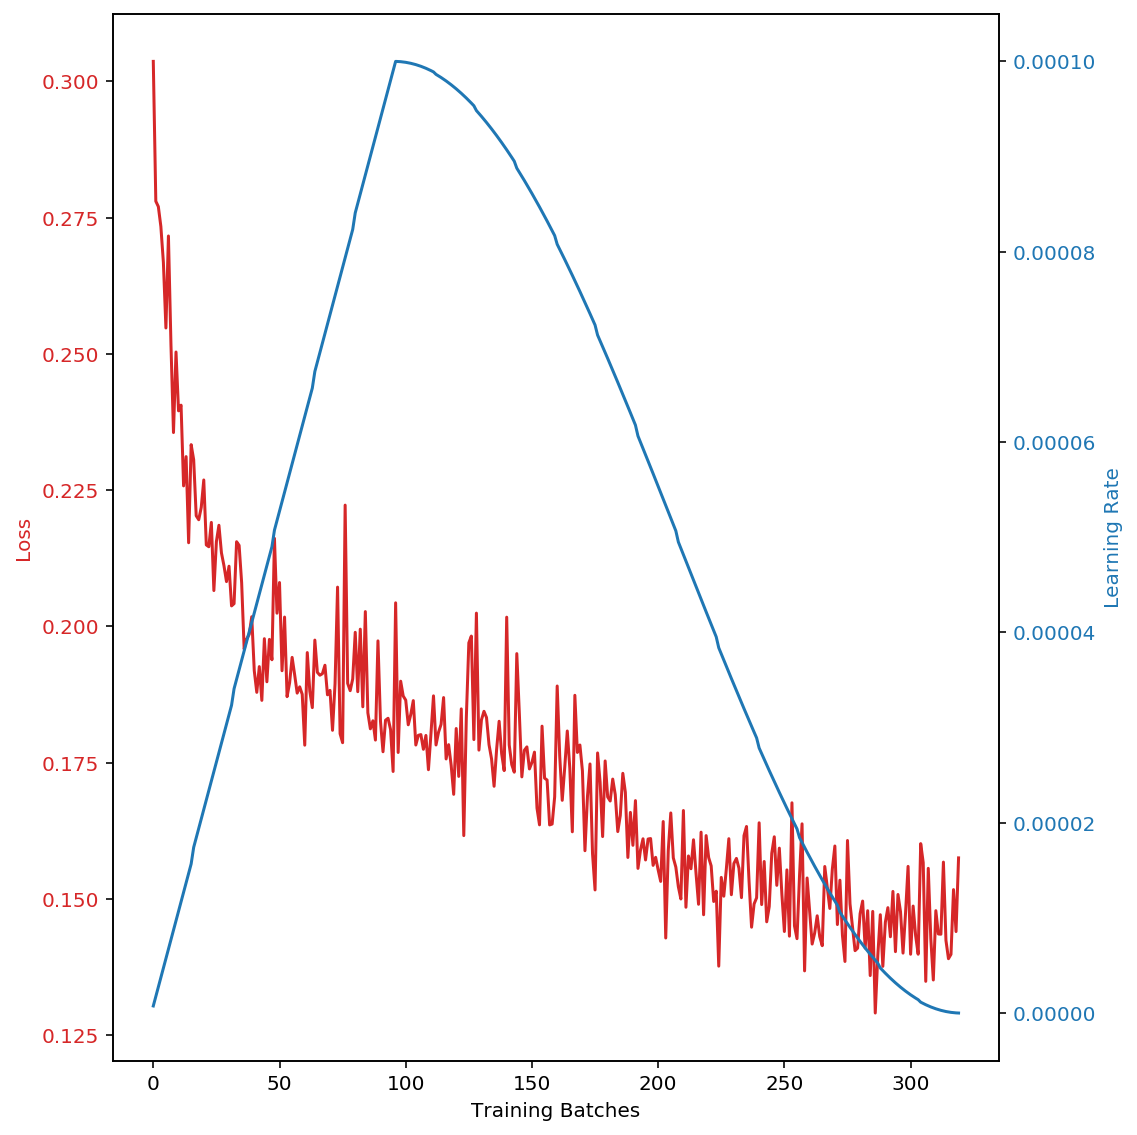

Proba       Preds    
         min   max   min max
Labels                      
0      0.167 0.779     0   1
1      0.252 0.706     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.573,"[0.4265304505825043, 0.5734695196151733]",1,1,0.361,"[0.6392946243286133, 0.3607054352760315]",0,0,0.355,"[0.6445128321647644, 0.3554871082305908]",0,1
1,0.290,"[0.7104015350341797, 0.2895985245704651]",0,0,0.351,"[0.6488524675369263, 0.3511475622653961]",0,1,0.427,"[0.5733388662338257, 0.4266611635684967]",0,0
2,0.623,"[0.37689676880836487, 0.6231032609939575]",1,1,0.328,"[0.6722395420074463, 0.3277604281902313]",0,0,0.500,"[0.500424325466156, 0.4995756447315216]",0,1
3,0.447,"[0.5530675649642944, 0.44693246483802795]",0,1,0.318,"[0.6824303865432739, 0.31756964325904846]",0,0,0.577,"[0.42318975925445557, 0.5768102407455444]",1,0
4,0.647,"[0.35307562351226807, 0.6469243764877319]",1,0,0.572,"[0.4283226728439331, 0.5716773271560669]",1,1,0.469,"[0.5310060977935791, 0.4689939022064209]",0,0


scores =  {'map': '0.5929', 'acc': '0.5520', 'auc': '0.6182'}


train   val
mean_or_std metric               
mean        map       0.766 0.593
            accuracy  0.774 0.552
            auc       0.854 0.618
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.852  0.783 0.816 5450.000     0.542  0.676 0.601 250.000
pos     0.661  0.758 0.706 3050.000     0.569  0.428 0.489 250.000

In [14]:
batch_size=64
epochs = 10

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[2, 7, 9, 11, 14, 17, 19, 24, 28],
    show_model_stats=False,
    sampling_policy="without_replacement",
    accumulation_steps=4,
)
r1, p1 = results, prfs
results
prfs


In [15]:
batch_size=64
epochs = 15

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[2, 7, 9, 11, 14, 17, 19, 24, 28],
    show_model_stats=False,
    sampling_policy="without_replacement",
    accumulation_steps=4,
)
r2, p2 = results, prfs
results
prfs



LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Load LXMERT pre-trained model from /home/ahemf/.pytorch_pretrained_bert/acfabf2c6d3708e226675d880fed09a14878ef2aee577eeefa8e27a6a22d5b3e.5392626539fa4619737ae314ee55e15de3097750e782865c604a83312ea77251

Weights in loaded but not in model:
answer_head.logit_fc.0.bias
answer_head.logit_fc.0.weight
answer_head.logit_fc.2.bias
answer_head.logit_fc.2.weight
answer_head.logit_fc.3.bias
answer_head.logit_fc.3.weight
cls.predictions.bias
cls.predictions.decoder.weight
cls.predictions.transform.LayerNorm.bias
cls.predictions.transform.LayerNorm.weight
cls.predictions.transform.dense.bias
cls.predictions.transform.dense.weight
cls.seq_relationship.bias
cls.seq_relationship.weight
obj_predict_head.decoder_dict.attr.bias
obj_predict_head.decoder_dict.attr.weight
obj_predict_head.decoder_dict.feat.bias
obj_predict_head.decoder_dict.feat.weight
obj_predict_head.decoder_dict.obj.bias
obj_predict_head.decoder_dict.obj.weight
obj_predict_head.t

Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.


N tokens Out =  132 Classifier Dims =  256 Matches embedding_dims:  False
Autocast =  True Epochs =  30 Divisor = 2 Examples = 4250 Batch Size =  64
Training Samples =  8500 Weighted Sampling =  True Num Batches =  67 Accumulation steps =  4
[WARN]: Number of training batches not divisible by accumulation steps, some training batches will be wasted due to this.



Epoch =  1 Loss = 0.287965 LR = 0.00001111



Epoch =  2 Loss = 0.242440 LR = 0.00002222


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch =  15 Loss = 0.166423 LR = 0.00008117



Epoch =  16 Loss = 0.163380 LR = 0.00007500



Epoch =  17 Loss = 0.153666 LR = 0.00006827


Proba       Preds    
         min   max   min max
Labels                      
0      0.254 0.715     0   1
1      0.293 0.670     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.506,"[0.4942636489868164, 0.5057363510131836]",1,1,0.547,"[0.45323070883750916, 0.5467692613601685]",1,1,0.556,"[0.444079726934433, 0.5559202432632446]",1,1
1,0.445,"[0.5554651021957397, 0.44453492760658264]",0,0,0.588,"[0.41242650151252747, 0.5875735282897949]",1,0,0.492,"[0.5079047679901123, 0.4920952618122101]",0,1
2,0.448,"[0.5516527891159058, 0.44834715127944946]",0,1,0.535,"[0.46505171060562134, 0.5349482893943787]",1,1,0.464,"[0.5357080698013306, 0.46429190039634705]",0,1
3,0.621,"[0.3788388669490814, 0.6211611032485962]",1,0,0.357,"[0.6431190371513367, 0.35688093304634094]",0,0,0.463,"[0.5369923114776611, 0.4630076587200165]",0,0
4,0.471,"[0.5292916297912598, 0.47070831060409546]",0,1,0.321,"[0.6793841123580933, 0.3206159174442291]",0,1,0.378,"[0.6219660639762878, 0.3780338764190674]",0,1


scores =  {'map': '0.5932', 'acc': '0.5620', 'auc': '0.6050'}
Epoch =  17 Train = 0.850991 Val = 0.605040



Epoch =  18 Loss = 0.146578 LR = 0.00006113



Epoch =  19 Loss = 0.145620 LR = 0.00005374


Proba       Preds    
         min   max   min max
Labels                      
0      0.195 0.754     0   1
1      0.274 0.703     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.602,"[0.39847663044929504, 0.6015233397483826]",1,0,0.418,"[0.581577718257904, 0.4184223413467407]",0,0,0.439,"[0.5609560012817383, 0.4390439987182617]",0,1
1,0.601,"[0.39876899123191833, 0.6012309789657593]",1,1,0.448,"[0.5522605180740356, 0.44773954153060913]",0,0,0.623,"[0.37726902961730957, 0.6227309703826904]",1,1
2,0.543,"[0.45687395334243774, 0.543126106262207]",1,1,0.556,"[0.44418618083000183, 0.5558137893676758]",1,1,0.483,"[0.5171107649803162, 0.4828892648220062]",0,0
3,0.629,"[0.37103071808815, 0.6289693117141724]",1,1,0.637,"[0.3629057705402374, 0.637094259262085]",1,1,0.310,"[0.6899725198745728, 0.31002748012542725]",0,1
4,0.356,"[0.6437317132949829, 0.3562682867050171]",0,0,0.492,"[0.507634699344635, 0.49236536026000977]",0,1,0.597,"[0.40340980887413025, 0.5965901613235474]",1,1


scores =  {'map': '0.6070', 'acc': '0.5760', 'auc': '0.6228'}
Epoch =  19 Train = 0.868995 Val = 0.622784



Epoch =  20 Loss = 0.142240 LR = 0.00004626



Epoch =  21 Loss = 0.141257 LR = 0.00003887



Epoch =  22 Loss = 0.136900 LR = 0.00003173



Epoch =  23 Loss = 0.139276 LR = 0.00002500



Epoch =  24 Loss = 0.135749 LR = 0.00001883


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Predict

In [6]:
adam = torch.optim.Adam
adam_params = params = dict(lr=1e-4, weight_decay=1e-2)
optimizer = adam
optimizer_params = adam_params

model_fn = model_builder(VilBertVisualBertModel,
                         dict(model_name={
                             "lxmert":
                             dict(finetune=True,
                                  dropout=0.1,
                                  gaussian_noise=0.2),
                            },
                              num_classes=2,
                              gaussian_noise=0.2,
                              dropout=0.25,
                              featurizer="pass",
                              final_layer_builder=fb_1d_loss_builder,
                              internal_dims=768,
                              classifier_dims=768,
                              n_tokens_in=96,
                              n_tokens_out=96,
                              n_layers=2,
                              loss="focal",
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.0,
                              word_masking_proba=0.2),
                         per_param_opts_fn=combo_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

# model, opt = model_fn()
# model

##
## MMBT Region, Per module regularization, word_masking_proba, reg_scheduling

## Next accumulation_steps


Overriding option config to projects/hateful_memes/configs/vilbert/from_cc.yaml
Overriding option model to vilbert
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to vilbert.finetuned.hateful_memes.from_cc_original
Overriding option evaluation.predict to true


Some weights of the model checkpoint at bert-base-uncased were not used when initializing ViLBERTBase: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing ViLBERTBase from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing ViLBERTBase from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViLBERTBase were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.v_embeddings.image_embeddings.weight', 'bert.v_embeddings.image_embeddings.bias', 'bert.v_embeddings.image_location_embeddings.weight', 'bert.v_embeddings.image_location_embeddings.bias', 'bert.v_embeddings.LayerNorm.weight', 'bert.v_embeddings.LayerNorm.

Overriding option config to projects/hateful_memes/configs/visual_bert/from_coco.yaml
Overriding option model to visual_bert
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to visual_bert.finetuned.hateful_memes.from_coco
Overriding option evaluation.predict to true


Some weights of VisualBERTBase were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.embeddings.token_type_embeddings_visual.weight', 'bert.embeddings.position_embeddings_visual.weight', 'bert.embeddings.projection.weight', 'bert.embeddings.projection.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Load LXMERT pre-trained model from /home/ahemf/.pytorch_pretrained_bert/acfabf2c6d3708e226675d880fed09a14878ef2aee577eeefa8e27a6a22d5b3e.5392626539fa4619737ae314ee55e15de3097750e782865c604a83312ea77251

Weights in loaded but not in model:
answer_head.logit_fc.0.bias
answer_head.logit_fc.0.weight
answer_head.logit_fc.2.bias
answer_head.logit_fc.2.weight
answer_head.logit_fc.3.bias
answer_head.logit_fc.3.weight
cls.predictions.bias
cls.predictions.decoder.weight
cls.predictions.transform.LayerNorm.bias
cls.predictions.transform.LayerNorm.weight
cls.predictions.transform.dense.bias
cls.predictions.transform.dense.weight
cls.seq_relationship.bias
cls.seq_relationship.weight
obj_predict_head.decoder_dict.attr.bias
obj_predict_head.decoder_dict.attr.weight
obj_predict_head.decoder_dict.feat.bias
obj_predict_head.decoder_dict.feat.weight
obj_predict_head.decoder_dict.obj.bias
obj_predict_head.decoder_dict.obj.weight
obj_predict_head.tr

Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.
Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.


N tokens Out =  722
Autocast =  True Epochs =  14 Divisor = 2 Examples = 4500 Batch Size =  4
Training Samples =  9000 Weighted Sampling =  True Num Batches =  1125 Accumulation steps =  16
[WARN]: Number of training batches not divisible by accumulation steps, some training batches will be wasted due to this.


FeatureExtractor : Loaded Model...
LXMERTFeatureExtractor : Loaded Model...

Epoch =  1 Loss = 0.229189 LR = 0.00023810


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch =  4 Loss = 0.140130 LR = 0.00095238


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch =  7 Loss = 0.154248 LR = 0.00081174



Epoch =  8 Loss = 0.157731 LR = 0.00067268



Epoch =  9 Loss = 0.158405 LR = 0.00051603



Epoch =  10 Loss = 0.153493 LR = 0.00035774



Epoch =  11 Loss = 0.152576 LR = 0.00021394



Epoch =  12 Loss = 0.153589 LR = 0.00009929



Epoch =  13 Loss = 0.147211 LR = 0.00002547



Epoch =  14 Loss = 0.145344 LR = 0.00000000



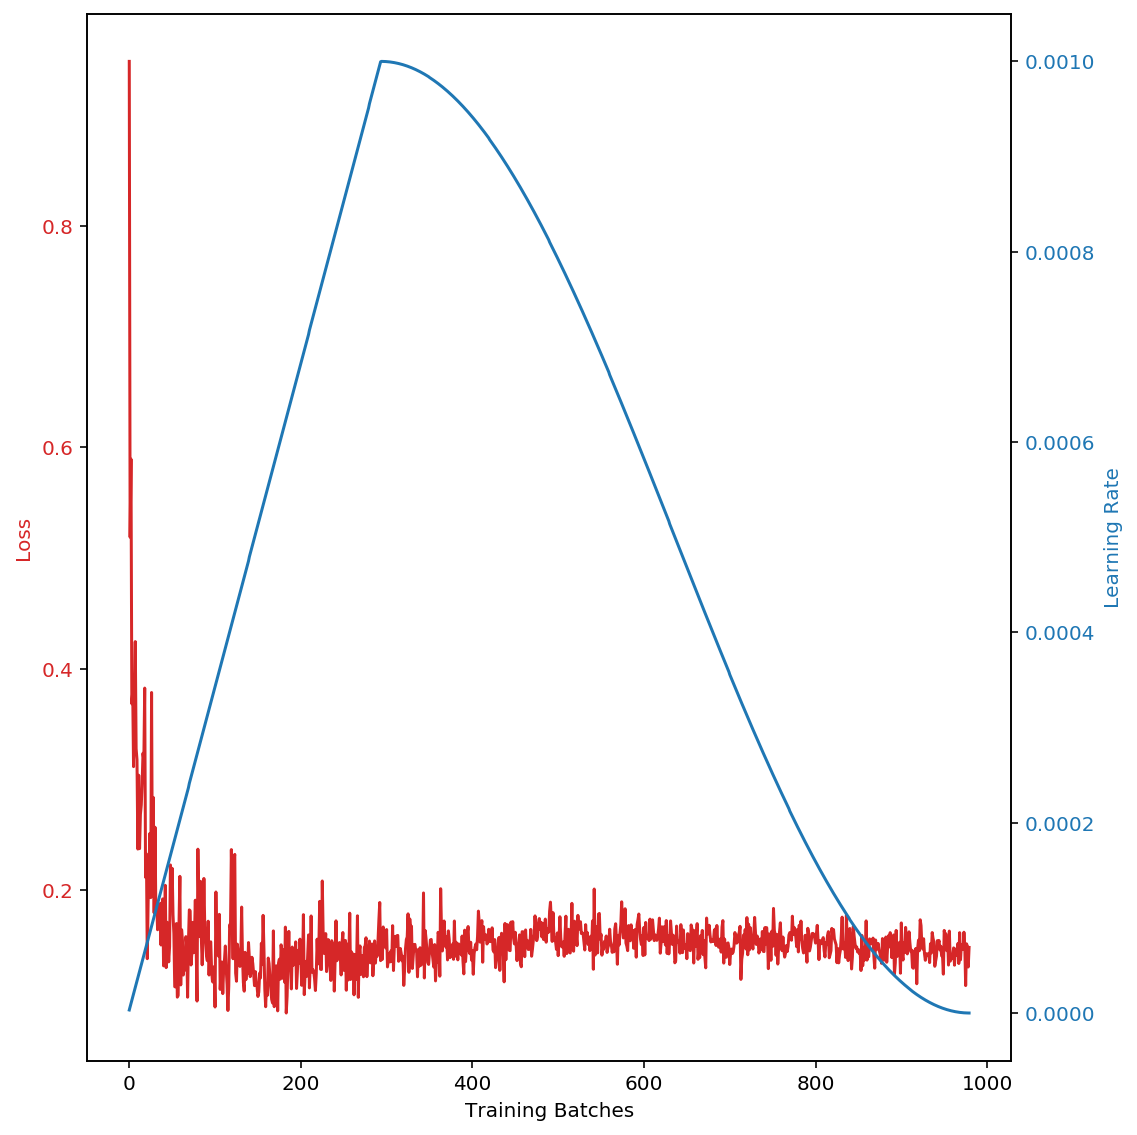

,id,proba,label
655,84517,0.511,1
433,71063,0.671,1
414,85042,0.613,1


In [7]:

torch.backends.cudnn.enabled = False
batch_size = 4
epochs = 7

submission, text_model = train_and_predict(
    model_fn,
    data,
    batch_size,
    epochs,
    scheduler_init_fn=scheduler_init_fn,
    accumulation_steps=16,
    model_call_back=reg_sched,
    sampling_policy="without_replacement") # "without_replacement"

submission.to_csv("submission.csv", index=False)
submission.sample(3)


In [8]:
data["test"] = data["dev"]
sf, _ = predict(text_model, data, batch_size)

print(sf.head())

from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

labels_list = data["test"].label
proba_list = sf.proba
predictions_list = sf.label

auc = roc_auc_score(labels_list, proba_list)
# p_micro, r_micro, f1_micro, _ = precision_recall_fscore_support(labels_list, predictions_list, average="micro")
prfs = precision_recall_fscore_support(labels_list, predictions_list, average=None, labels=[0, 1])
map = average_precision_score(labels_list, proba_list)
acc = accuracy_score(labels_list, predictions_list)
validation_scores = [map, acc, auc]
print("scores = ", dict(zip(["map", "acc", "auc"], ["%.4f" % v for v in validation_scores])))



      id  proba  label
0   8291  0.632      1
1  46971  0.350      0
2   3745  0.543      1
3  83745  0.594      1
4  80243  0.617      1
scores =  {'map': '0.6912', 'acc': '0.6920', 'auc': '0.7407'}


In [ ]:
submission.sample(10)
submission.label.value_counts()

In [ ]:


batch_size = 32
epochs = 7

submission, text_model = train_and_predict(
    model_fn,
    data,
    batch_size,
    epochs,
    scheduler_init_fn=scheduler_init_fn,
    accumulation_steps=1,
    model_call_back=reg_sched,
    sampling_policy=None) # "without_replacement"

submission.to_csv("submission2.csv", index=False)
submission.sample(3)
